In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

min_error = 0.000001

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [3]:
class AutoEncoder:
    def __init__(self, input_size, hidden_size, activation_function, previous=None, outputX=None, inputX=None):
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.tf_session = None

        self.weight_e = tf.Variable(tf.random_normal([input_size, hidden_size]))
        self.bias_e = tf.Variable(tf.random_normal([hidden_size]))

        if previous:
            self.previous = previous
        else:
            self.previous = None

        if inputX:
            self.inputX = inputX
        else:
            self.inputX = tf.placeholder('float', [None, input_size])

        if outputX!= None :
            self.outputX = outputX
        else:
            self.outputX = self.inputX

        self.activation_function = activation_function

        self.encoder = activation_function(tf.add(tf.matmul(self.inputX, self.weight_e), self.bias_e))

        self.weight_d = tf.transpose(self.weight_e)
        self.bias_d = tf.Variable(tf.random_normal([input_size]))

        self.decoder = activation_function(tf.add(tf.matmul(self.encoder, self.weight_d), self.bias_d))

    def set_weights_biases(self, weight_e, bias_e, bias_d, inputX=None):
        self.weight_e = weight_e
        self.weight_d = tf.transpose(weight_e)
        self.bias_e = bias_e
        self.bias_d = bias_d
        if inputX:
            self.encoder = self.activation_function(tf.add(tf.matmul(inputX, self.weight_e), self.bias_e))
        else:
            self.encoder = self.activation_function(tf.add(tf.matmul(self.inputX, self.weight_e), self.bias_e))

        self.decoder = self.activation_function(tf.add(tf.matmul(self.encoder, self.weight_d), self.bias_d))

    def get_trained_values(self, inputX=None):
        act_weight_e = tf.constant(self.tf_session.run(self.weight_e))
        act_bias_e = tf.constant(self.tf_session.run(self.bias_e))

        act_bias_d = tf.constant(self.tf_session.run(self.bias_d))

        act_auto_encoder = AutoEncoder(self.input_size, self.hidden_size, self.activation_function, self.previous)
        act_auto_encoder.set_weights_biases(act_weight_e, act_bias_e, act_bias_d, inputX)

        return act_auto_encoder

    def set_constants(self, inputX=None):
        self.weight_e = tf.constant(self.tf_session.run(self.weight_e))
        self.bias_e = tf.constant(self.tf_session.run(self.bias_e))
        if inputX:
            self.inputX = inputX

        self.encoder = self.activation_function(tf.add(tf.matmul(self.inputX, self.weight_e), self.bias_e))

        self.weight_d = tf.constant(self.tf_session.run(self.weight_d))
        self.bias_d = tf.constant(self.tf_session.run(self.bias_d))

        self.decoder = self.activation_function(tf.add(tf.matmul(self.encoder, self.weight_d), self.bias_d))

    def output(self, input_data, session=None):
        if session:
            self.tf_session = session

        if self.previous:
            input_data = self.previous.output(input_data, self.tf_session)

        return self.tf_session.run(self.encoder, feed_dict={self.inputX:input_data})

    def unsupervised_train(self, input_data, training_epochs=20, output_data = [], learning_rate=0.01, display_steps=10, batch_size=256):

        print(len(output_data))
        if len(output_data) == 0:
            y_pred = self.decoder
        else:
            y_pred = self.encoder
        y_true = self.outputX

        cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
        optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

        with tf.Session() as self.tf_session:

            input_size = len(input_data)
            self.tf_session.run(tf.global_variables_initializer())
            total_batch = int(input_size / batch_size)
            for epoch in range(training_epochs):
                start = time.time()
                count = 0
                cst = 0.0

                for i in range(total_batch):
                    end = count + batch_size
                    if end > input_size:
                        end = input_size

                    if self.previous:
                        batch_xs = self.previous.output(input_data[count:end], self.tf_session)
                    else:
                        batch_xs = input_data[count:end]

                    if len(output_data) == 0:
                        batch_ys = batch_xs
                    else:
                        batch_ys = output_data[count:end]

                    _, c = self.tf_session.run([optimizer, cost],
                                               feed_dict={self.inputX: batch_xs, self.outputX: batch_ys})
                    cst = cst + c
                    count = end

                cst = cst / total_batch
                if cst < min_error:
                    break

                end = time.time()
                if epoch % display_steps == 0:
                    print("Epoch:", '%04d' % (epoch + 1),
                          "cost=", "{:.9f}".format(cst))
                    print('epoch took {}'.format((end - start) * 1000))


            print("Optimization Finished!")

            self.set_constants()

            return self

In [4]:
def mergeLayers(layers):
    inputX = layers[0].inputX
    for layer in layers:
        inputX = layer.activation_function(tf.add(tf.matmul(inputX, layer.weight_e), layer.bias_e))

    layers.reverse()

    output = inputX
    for layer in layers:
        output = layer.activation_function(tf.add(tf.matmul(output, layer.weight_d), layer.bias_d))

    layers.reverse()
    return output, layers[0].inputX

def getEncoder(layers):
    inputX = layers[0].inputX
    for layer in layers:
        inputX = layer.activation_function(tf.add(tf.matmul(inputX, layer.weight_e), layer.bias_e))


    return inputX, layers[0].inputX

def finalLayer(layers):
    inputX = layers[0].inputX
    for layer in layers:
        weight = tf.Variable(layer.weight_e)
        bias = tf.Variable(layer.bias_e)
        inputX = layer.activation_function(tf.add(tf.matmul(inputX, weight), bias))

    return inputX, layers[0].inputX

In [5]:
def final_layer_train(encoder_pt, input_count, hidden_size, input_data, output_data, training_epochs=20, learning_rate=0.01, display_steps=10, batch_size=256):
    weight = tf.Variable(tf.random_normal([input_count, hidden_size]))
    bias = tf.Variable(tf.random_normal([hidden_size]))

    encoder = tf.nn.sigmoid(tf.add(tf.matmul(encoder_pt, weight), bias))

    y_true = outputX
    y_pred = encoder

    cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
    optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

    input_size =len(input_data)

    with tf.Session() as def_session:
        def_session.run(tf.global_variables_initializer())
        for epoch in range(training_epochs):
            total_batch = int(input_size / batch_size)
            count = 0
            cst = 0.0
            for i in range(total_batch):
                end = count + batch_size
                if end > input_size:
                    end = input_size

                batch_xs = input_data[count:end]
                batch_ys = output_data[count:end]

                _, c = def_session.run([optimizer, cost],
                                       feed_dict={inputX: batch_xs, outputX: batch_ys})

                cst += c
                count = end
            cst = cst / total_batch
            if cst < min_error:
                break

            if epoch % display_steps == 0:
                print("Epoch:", '%04d' % (epoch + 1),
                      "cost=", "{:.9f}".format(cst))

        print("Optimization Finished!")

        correct_prediction = tf.equal(tf.argmax(encoder, 1), tf.argmax(outputX, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        print(def_session.run(accuracy, feed_dict={inputX: mnist.test.images, outputX: mnist.test.labels}))

Epoch: 0001 cost= 0.332113190
Epoch: 0002 cost= 0.031145567
Epoch: 0003 cost= 0.018562164
Epoch: 0004 cost= 0.016293228
Epoch: 0005 cost= 0.015120312
Epoch: 0006 cost= 0.014442657
Epoch: 0007 cost= 0.013938095
Epoch: 0008 cost= 0.013225811
Epoch: 0009 cost= 0.012839099
Epoch: 0010 cost= 0.012532365
Epoch: 0011 cost= 0.011093671
Epoch: 0012 cost= 0.010933351
Epoch: 0013 cost= 0.010782929
Epoch: 0014 cost= 0.010605999
Epoch: 0015 cost= 0.010475647
Epoch: 0016 cost= 0.010350195
Epoch: 0017 cost= 0.010240653
Epoch: 0018 cost= 0.010129978
Epoch: 0019 cost= 0.010024736
Epoch: 0020 cost= 0.009953568
Epoch: 0021 cost= 0.009878016
Epoch: 0022 cost= 0.009800524
Epoch: 0023 cost= 0.009724816
Epoch: 0024 cost= 0.009662129
Epoch: 0025 cost= 0.009616560
Epoch: 0026 cost= 0.009570906
Epoch: 0027 cost= 0.009516129
Epoch: 0028 cost= 0.009460301
Epoch: 0029 cost= 0.009414184
Epoch: 0030 cost= 0.009364502
Epoch: 0031 cost= 0.009324728
Epoch: 0032 cost= 0.009297021
Epoch: 0033 cost= 0.009274826
Epoch: 003

Epoch: 0114 cost= 0.002342453
Epoch: 0115 cost= 0.002326931
Epoch: 0116 cost= 0.002310819
Epoch: 0117 cost= 0.002305047
Epoch: 0118 cost= 0.002304912
Epoch: 0119 cost= 0.002297939
Epoch: 0120 cost= 0.002296025
Epoch: 0121 cost= 0.002293414
Epoch: 0122 cost= 0.002292790
Epoch: 0123 cost= 0.002289937
Epoch: 0124 cost= 0.002287846
Epoch: 0125 cost= 0.002270663
Epoch: 0126 cost= 0.002257422
Epoch: 0127 cost= 0.002249976
Epoch: 0128 cost= 0.002243881
Epoch: 0129 cost= 0.002243984
Epoch: 0130 cost= 0.002242125
Epoch: 0131 cost= 0.002234868
Epoch: 0132 cost= 0.002239357
Epoch: 0133 cost= 0.002226356
Epoch: 0134 cost= 0.002229586
Epoch: 0135 cost= 0.002216524
Epoch: 0136 cost= 0.002209040
Epoch: 0137 cost= 0.002210008
Epoch: 0138 cost= 0.002209368
Epoch: 0139 cost= 0.002205307
Epoch: 0140 cost= 0.002205552
Epoch: 0141 cost= 0.002204573
Epoch: 0142 cost= 0.002199118
Epoch: 0143 cost= 0.002198899
Epoch: 0144 cost= 0.002194571
Epoch: 0145 cost= 0.002190032
Epoch: 0146 cost= 0.002180406
Epoch: 014

In [6]:
%matplotlib inline

In [ ]:
outputX = tf.placeholder('float', [None, 10])
layer1 = AutoEncoder(784, 256, tf.nn.sigmoid)
layer2 = AutoEncoder(256, 256, tf.nn.sigmoid, layer1)
layer3 = AutoEncoder(256, 128, tf.nn.sigmoid, layer2)
layer4 = AutoEncoder(128, 128, tf.nn.sigmoid, layer3)
layer5 = AutoEncoder(128, 64, tf.nn.sigmoid, layer4)
#layer4 = AutoEncoder(128, 10, tf.nn.sigmoid, layer3, outputX)


examples_to_show = 10

layers = []

layers.append(layer1.unsupervised_train(mnist.train.images, 40))
layers.append(layer2.unsupervised_train(mnist.train.images, 40))
layers.append(layer3.unsupervised_train(mnist.train.images, 40))
layers.append(layer4.unsupervised_train(mnist.train.images, 40))
layers.append(layer5.unsupervised_train(mnist.train.images, 40))
#layers.append(layer4.unsupervised_train(mnist.train.images, 320, mnist.train.labels))

decoder, input = mergeLayers(layers)

#encoder, inputX = getEncoder(layers)

encoder_pt, inputX = finalLayer(layers)

final_layer_train(encoder_pt, 64, 10, mnist.train.images[:10000], mnist.train.labels[:10000], 40)

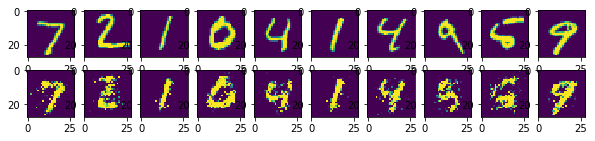

In [7]:
with tf.Session() as def_session:
    def_session.run(tf.global_variables_initializer())
    encode_decode = def_session.run(decoder, feed_dict={input:mnist.test.images[:examples_to_show]})

f, a = plt.subplots(2, 10, figsize=(10, 2))
for i in range(examples_to_show):
    a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
    a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))